<a href="https://colab.research.google.com/github/Mageed-Ghaleb/OptimizationSystems-Course/blob/main/Lab_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 — Systems Modeling & Tooling (Optimization Systems)

**Course:** Optimization Systems (Graduate)  
**Lecture:** 3 — Network Optimization (Min-Cost Flow, Assignment, and Sensitivity via Shadow Prices (LP duals))

**Goals:**

- Build a network model from a short case narrative

- Solve min-cost flow with a specialized network solver

- Solve the same model as an LP and interpret duals (shadow prices / node potentials)

- Verify reduced-cost optimality conditions

- Run a small perturbation experiment and compare observed changes to dual predictions

In [14]:
# If you already have these, you can comment out.
%pip -q install ortools scipy networkx pandas matplotlib

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from ortools.graph.python import min_cost_flow
from ortools.sat.python import cp_model

from scipy.optimize import linprog


## Part A — Min-Cost Flow (Relief Distribution)

A relief agency must ship supplies from depots (supplies) through hubs (transshipment) to shelters (demands).
Each route has:
- a **per-unit cost** (shipping + handling),
- a **capacity** (max units that can move today).

Your job: find the minimum-cost routing that satisfies all demands.

In [10]:
# Node supply b_i: positive = supply, negative = demand, 0 = transshipment
nodes = ["D1","D2","H1","H2","S1","S2","S3"]

# b[i] > 0 supply, b[i] < 0 demand, b[i]=0 transshipment
b = {"D1": +40, "D2": +30, "H1": 0, "H2": 0, "S1": -20, "S2": -25, "S3": -25}
assert sum(b.values()) == 0

# arcs = (u, v, unit_cost, capacity)
arcs = [
    ("D1","H1", 2, 40),
    ("D1","H2", 4, 20),
    ("D2","H1", 3, 30),
    ("D2","H2", 1, 30),
    ("H1","S1", 2, 25),
    ("H1","S2", 5, 30),
    ("H2","S2", 2, 20),
    ("H2","S3", 3, 30),
    ("H1","S3", 6, 10),  # expensive backup route
]

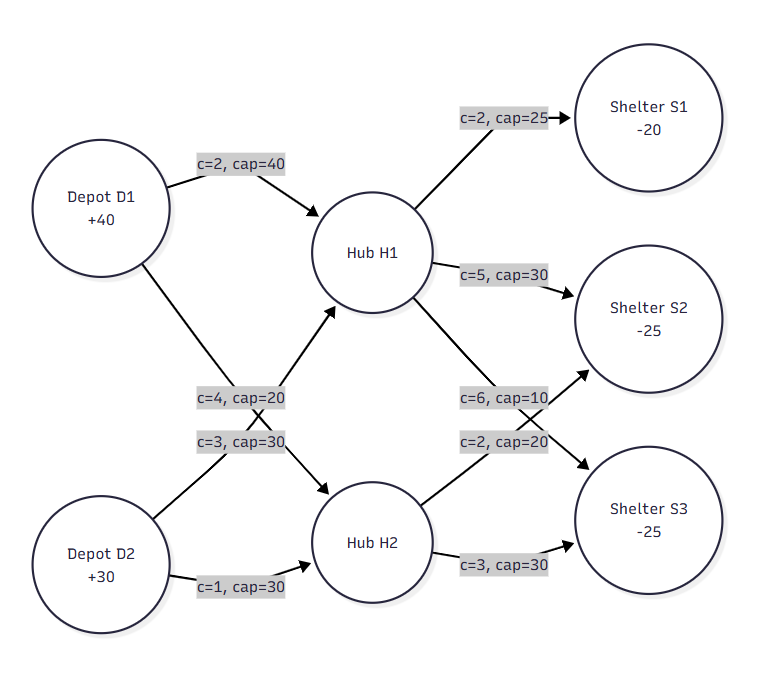

### Solve with OR-Tools MinCostFlow

This solver is specialized for network flow and is typically much faster than a generic LP solver for large networks.

We will:
1) add arcs with costs and capacities,
2) set node supplies/demands,
3) solve and print nonzero flows.

In [3]:
### Solve with OR-Tools Min-Cost Flow
from ortools.graph.python import min_cost_flow

# Build solver
mcf = min_cost_flow.SimpleMinCostFlow()

node_index = {n:i for i,n in enumerate(nodes)}

# Add arcs
for (u,v,cost,cap) in arcs:
    mcf.add_arc_with_capacity_and_unit_cost(node_index[u], node_index[v],
                                            cap, cost)

# Set supplies
for n in nodes:
    mcf.set_node_supply(node_index[n], b[n])

status = mcf.solve()

if status != mcf.OPTIMAL:
    raise RuntimeError(f"MinCostFlow not optimal. Status={status}")

print("Optimal total cost:", mcf.optimal_cost())

# Print nonzero flows
sol = []
for a in range(mcf.num_arcs()):
    flow = mcf.flow(a)
    if flow > 1e-9:
        u = nodes[mcf.tail(a)]
        v = nodes[mcf.head(a)]
        sol.append((u,v,flow,mcf.unit_cost(a), mcf.capacity(a)))
pd.DataFrame(sol, columns=["from","to","flow","unit_cost","capacity"])

Optimal total cost: 320


,from,to,flow,unit_cost,capacity
0,D1,H1,25,2,40
1,D1,H2,15,4,20
2,D2,H2,30,1,30
3,H1,S1,20,2,25
4,H1,S2,5,5,30
5,H2,S2,20,2,20
6,H2,S3,25,3,30


**How to read the flow table**
- Each row is an arc (from → to).
- `flow` is the optimal quantity sent on that arc.
- Compare flows to capacities:
  - if `flow == capacity`, that arc is a potential bottleneck.
- The solver's `Optimal total cost` equals sum(flow * unit_cost) over used arcs.

## Part B — Assignment (CP-SAT)

We assign 4 analysts to 4 tasks. Each analyst must get exactly one task and each task exactly one analyst.

We minimize total cost.
(You can switch to maximize "value" by changing the objective.)

In [12]:
### Assignment Data
workers = ["A1","A2","A3","A4"]
tasks = ["T1","T2","T3","T4"]

cost = {
    ("A1","T1"): 9, ("A1","T2"): 2, ("A1","T3"): 7, ("A1","T4"): 8,
    ("A2","T1"): 6, ("A2","T2"): 4, ("A2","T3"): 3, ("A2","T4"): 7,
    ("A3","T1"): 5, ("A3","T2"): 8, ("A3","T3"): 1, ("A3","T4"): 8,
    ("A4","T1"): 7, ("A4","T2"): 6, ("A4","T3"): 9, ("A4","T4"): 4,
}

In [15]:
### CP-SAT assignment solve
model = cp_model.CpModel()
x = {(w,t): model.NewBoolVar(f"x[{w},{t}]") for w in workers for t in tasks}

# each worker exactly one task
for w in workers:
    model.Add(sum(x[(w,t)] for t in tasks) == 1)

# each task exactly one worker
for t in tasks:
    model.Add(sum(x[(w,t)] for w in workers) == 1)

model.Minimize(sum(cost[(w,t)] * x[(w,t)] for w in workers for t in tasks))

solver = cp_model.CpSolver()
status = solver.Solve(model)

if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    raise RuntimeError("No solution found.")

assignments = []
for w in workers:
    for t in tasks:
        if solver.Value(x[(w,t)]) == 1:
            assignments.append((w,t,cost[(w,t)]))

print("Total cost:", sum(c for _,_,c in assignments))
pd.DataFrame(assignments, columns=["worker","task","cost"])

Total cost: 13


,worker,task,cost
0,A1,T2,2
1,A2,T1,6
2,A3,T3,1
3,A4,T4,4


## Part C — Sensitivity via Shadow Prices (LP duals)

OR-Tools' specialized flow solvers do not expose LP dual variables (shadow prices).
To get shadow prices, we solve the same min-cost flow as a **linear program (LP)**.

We will:
1) build the LP constraints,
2) solve with SciPy/HiGHS,
3) extract node duals for flow-balance constraints,
4) change one supply/demand value and compare:
   - **predicted cost change** from duals vs
   - **observed cost change** from re-solving.

In [16]:
### build the LP (A_eq x = b, bounds)
var_list = [(u,v) for (u,v,cost,cap) in arcs]
n = len(var_list)

c = np.array([cost for (u,v,cost,cap) in arcs], dtype=float)

node_index = {n:i for i,n in enumerate(nodes)}
A_eq = np.zeros((len(nodes), n))
b_eq = np.array([b[nm] for nm in nodes], dtype=float)

for k,(u,v) in enumerate(var_list):
    A_eq[node_index[u], k] += 1   # outflow
    A_eq[node_index[v], k] -= 1   # inflow

bounds = [(0, cap) for (u,v,cost,cap) in arcs]

In [17]:
### extract node duals (shadow prices)
pi = res.eqlin.marginals  # one dual per node balance equation
pd.DataFrame({"node": nodes, "dual_pi": pi})

,node,dual_pi
0,D1,4.0
1,D2,5.0
2,H1,2.0
3,H2,-0.0
4,S1,-0.0
5,S2,-3.0
6,S3,-3.0


**How to interpret `dual_pi` (node shadow prices)**

Each node has a flow-balance constraint.
A node's dual value measures how the optimal cost would change if we *perturb* that node's net supply/demand,
while keeping the total sum of supplies/demands balanced (so the model stays feasible).

We will verify the dual interpretation with an experiment next.

In [18]:
### perturbation test
def solve_with_b(b_override):
    b_vec = np.array([b_override[nm] for nm in nodes], dtype=float)
    r = linprog(c, A_eq=A_eq, b_eq=b_vec, bounds=bounds, method="highs")
    if not r.success:
        raise RuntimeError(r.message)
    return r

base_cost = res.fun

# Increase demand at S1 by 1 (more negative), compensate by increasing supply at D1 by 1
b2 = b.copy()
b2["S1"] -= 1
b2["D1"] += 1

res2 = solve_with_b(b2)
new_cost = res2.fun

observed = new_cost - base_cost
predicted = pi[node_index["D1"]]*(+1) + pi[node_index["S1"]]*(-1)

print("Base cost:", base_cost)
print("New cost :", new_cost)
print("Observed Δcost:", observed)
print("Dual-predicted Δcost:", predicted)

Base cost: 320.0
New cost : 324.0
Observed Δcost: 4.0
Dual-predicted Δcost: 4.0


## Wrap-up (answer in 5–10 sentences)

1) Which arcs were saturated (flow == capacity) and why do they matter?
2) In the perturbation test, did the duals predict the change in cost well?
3) How would you explain the meaning of a "high" shadow price at a node to a stakeholder?